In [1]:
# Standard imports for EDA
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw

sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# Paths — update if your structure differs
DATA_DIR = 'dataset'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_IMAGES_DIR = os.path.join(TRAIN_DIR, 'images')
ANNOT_DIR = os.path.join(TRAIN_DIR, 'annotations')
TEST_IMAGES_DIR = os.path.join(DATA_DIR, 'test', 'images')
SAMPLE_SUB = os.path.join(DATA_DIR, 'sample_submission.csv')

print('DATA_DIR:', DATA_DIR)
print('Train images dir exists:', os.path.isdir(TRAIN_IMAGES_DIR))
print('Annotations dir exists:', os.path.isdir(ANNOT_DIR))
print('Test images dir exists:', os.path.isdir(TEST_IMAGES_DIR))
print('Sample submission file exists:', os.path.isfile(SAMPLE_SUB))

DATA_DIR: dataset
Train images dir exists: True
Annotations dir exists: True
Test images dir exists: True
Sample submission file exists: True


In [3]:
# Preview the sample submission (if present)
if os.path.isfile(SAMPLE_SUB):
    display(pd.read_csv(SAMPLE_SUB).head())
else:
    print('No sample_submission.csv found')

,image_id,prediction_string
0,2015_00002.png,Bicycle 0 0 0 0 0.0
1,2015_00003.png,Bicycle 0 0 0 0 0.0
2,2015_00005.jpg,Bicycle 0 0 0 0 0.0
3,2015_00007.jpg,Bicycle 0 0 0 0 0.0
4,2015_00008.jpg,Bicycle 0 0 0 0 0.0


In [4]:
# List annotation files and counts
annots = sorted(glob.glob(os.path.join(ANNOT_DIR, '*.txt')))
n_annots = len(annots)
img_files = sorted(glob.glob(os.path.join(TRAIN_IMAGES_DIR, '*')))
n_images = len(img_files)
print(f'Found {n_images} train images and {n_annots} annotation files')

# show a few annotation filenames
annots[:10]

Found 2208 train images and 2208 annotation files


['dataset/train/annotations/2015_00001.png.txt',
 'dataset/train/annotations/2015_00004.jpg.txt',
 'dataset/train/annotations/2015_00006.jpg.txt',
 'dataset/train/annotations/2015_00010.jpg.txt',
 'dataset/train/annotations/2015_00013.jpg.txt',
 'dataset/train/annotations/2015_00018.jpg.txt',
 'dataset/train/annotations/2015_00020.jpg.txt',
 'dataset/train/annotations/2015_00021.jpg.txt',
 'dataset/train/annotations/2015_00022.jpg.txt',
 'dataset/train/annotations/2015_00023.jpg.txt']

In [5]:
# Helper: parse an annotation file robustly.
# Many datasets use: class x_center y_center width height   (YOLO)
# Other variants may include class names. We'll handle both.
def parse_annotation(path):
    with open(path, 'r') as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    parsed = []
    for ln in lines:
        tokens = ln.split()
        # If first token is numeric, treat as class index
        if len(tokens) == 0:
            continue
        first = tokens[0]
        if first.replace('.', '', 1).isdigit():
            # numeric first token -> either class index or x coordinate;
            # we assume first is class index when there are >=5 tokens
            if len(tokens) >= 5:
                cls = int(float(tokens[0]))
                rest = list(map(float, tokens[1:]))
                parsed.append({'class': cls, 'bbox': rest})
            else:
                # fallback: store raw tokens
                parsed.append({'raw': tokens})
        else:
            # first token is non-numeric — likely a class label
            label = first
            rest = []
            if len(tokens) > 1:
                try:
                    rest = list(map(float, tokens[1:]))
                except Exception:
                    rest = tokens[1:]
            parsed.append({'class': label, 'bbox': rest})
    return parsed

# Show parsed content for the first annotation (if any)
if annots:
    sample = annots[0]
    print('Sample annotation file:', os.path.basename(sample))
    display(parse_annotation(sample))
else:
    print('No annotation files to preview')

Sample annotation file: 2015_00001.png.txt


[{'class': '%', 'bbox': ['bbGt', 'version=3']},
 {'class': 'Bicycle',
  'bbox': [204.0, 28.0, 271.0, 193.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}]

Total annotation files: 2208
Total boxes: 9428


,class,count
0,People,2377
1,%,2208
2,Car,852
3,Chair,729
4,Table,472
5,Cup,471
6,Boat,425
7,Bottle,408
8,Bicycle,354
9,Motorbike,339


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_32918/2090231483.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts.head(20), x='count', y='class', palette='viridis')


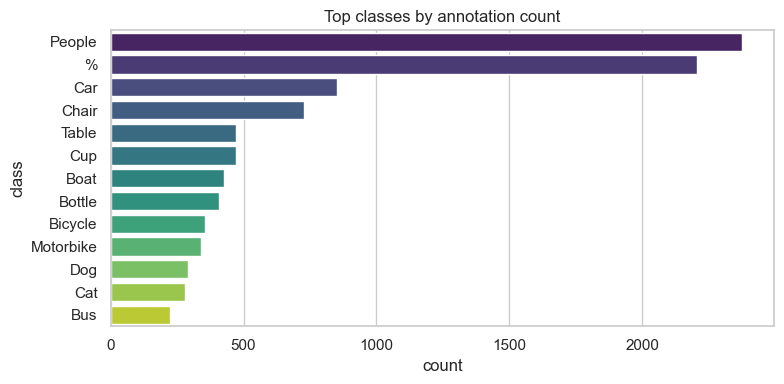

In [ ]:
# Create a class/count summary across annotations
from collections import Counter
import re
counter = Counter()
total_boxes = 0
def sanitize_class(cls):
    # Normalize class values and map clearly invalid tokens to 'unknown'
    if cls is None:
        return 'unknown'
    # keep integers as-is
    if isinstance(cls, (int,)):
        return int(cls)
    # handle floats that represent class indices
    if isinstance(cls, float):
        try:
            return int(cls)
        except Exception:
            return 'unknown'
    s = str(cls).strip()
    # numeric strings -> integers
    if re.fullmatch(r'\d+', s):
        return int(s)
    # if the token contains no alphanumeric character (e.g. '%'), treat as unknown
    if not re.search(r'[A-Za-z0-9]', s):
        return 'unknown'
    # otherwise return the cleaned string label
    return s

for a in annots:
    parsed = parse_annotation(a)
    for obj in parsed:
        total_boxes += 1
        raw_cls = obj.get('class', 'unknown')
        cls = sanitize_class(raw_cls)
        counter[cls] += 1

print('Total annotation files:', len(annots))
print('Total boxes:', total_boxes)

# Convert counter to DataFrame for plotting
if counter:
    df_counts = pd.DataFrame([{'class': k, 'count': v} for k, v in counter.items()])
    # convert numeric classes back to strings for a stable plot axis
    df_counts['class'] = df_counts['class'].apply(lambda x: str(x))
    df_counts = df_counts.sort_values('count', ascending=False).reset_index(drop=True)
    display(df_counts.head(20))
    plt.figure(figsize=(8,4))
    sns.barplot(data=df_counts.head(20), x='count', y='class', palette='viridis')
    plt.title('Top classes by annotation count')
    plt.tight_layout()
else:
    print('No class information parsed')

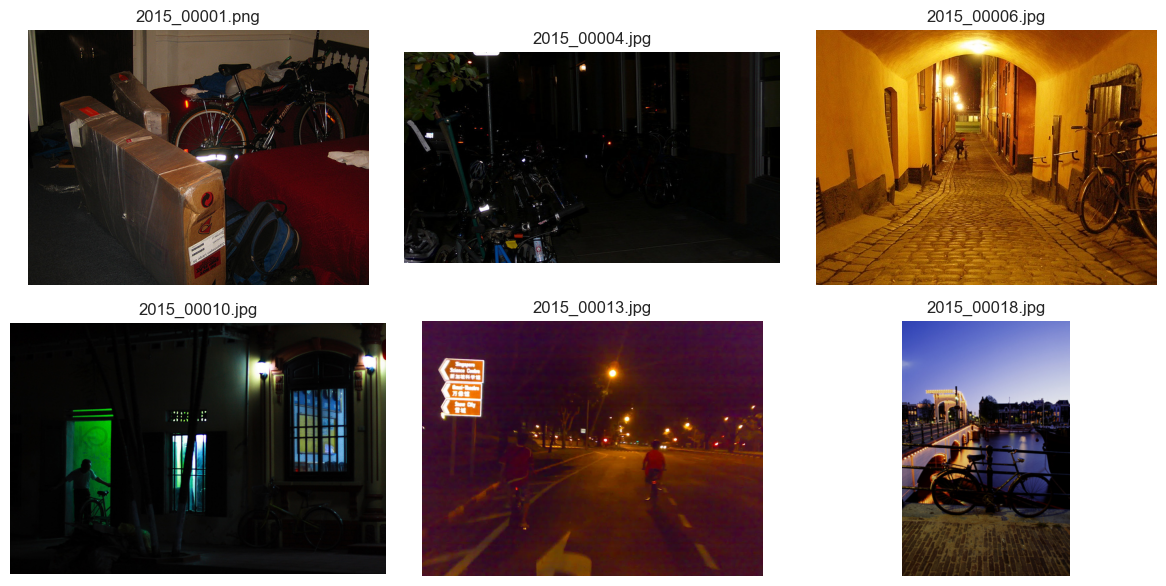

In [7]:
# Display a few sample images (with bounding boxes when possible)
def draw_boxes_on_image(img_path, ann_path=None, max_boxes=50):
    img = Image.open(img_path).convert('RGB')
    draw = ImageDraw.Draw(img)
    w, h = img.size
    if ann_path and os.path.isfile(ann_path):
        parsed = parse_annotation(ann_path)
        for i, obj in enumerate(parsed):
            if i >= max_boxes: break
            bbox = obj.get('bbox')
            # Try to handle YOLO-style normalized bboxes: cx, cy, w, h
            if isinstance(bbox, (list, tuple)) and len(bbox) >= 4 and all(isinstance(x, float) or isinstance(x, int) for x in bbox[:4]):
                cx, cy, bw, bh = map(float, bbox[:4])
                # If values look normalized (<=1), convert to pixel coordinates
                if max(cx, cy, bw, bh) <= 1.0:
                    box_w = bw * w
                    box_h = bh * h
                    left = (cx * w) - box_w/2
                    top = (cy * h) - box_h/2
                    right = left + box_w
                    bottom = top + box_h
                    draw.rectangle([left, top, right, bottom], outline='red', width=2)
                else:
                    # assume absolute coords: x1,y1,x2,y2 or x,y,w,h in pixels — try x,y,w,h
                    x, y, ww, hh = bbox[:4]
                    if ww > 1 and hh > 1:
                        draw.rectangle([x, y, x+ww, y+hh], outline='red', width=2)
    return img

# Show 6 sample images
sample_imgs = img_files[:6]
n = len(sample_imgs)
plt.figure(figsize=(12, 6))
for i, p in enumerate(sample_imgs):
    plt.subplot(2, 3, i+1)
    base = os.path.basename(p)
    # guess annotation file name by adding .txt or replacing extension with .txt
    ann_guess = os.path.join(ANNOT_DIR, os.path.splitext(base)[0] + '.txt')
    try:
        img = draw_boxes_on_image(p, ann_guess)
        plt.imshow(img)
    except Exception as e:
        print('Error opening', p, e)
        plt.imshow(Image.open(p).convert('RGB'))
    plt.axis('off')
    plt.title(base)
plt.tight_layout()

**Next steps**

- Run the cells to inspect actual counts and visuals for your local copy of the dataset.
- If class names mapping exists, add a mapping from class index -> label to the notebook for clearer plots.
- Optionally export `df_counts` to CSV for downstream model training analysis.
